<a href="https://colab.research.google.com/github/ZoeyLLL/Risk_Factors_of_Alzheimer-s_Disease/blob/main/Method_2)MLP_with_3_Numeric_Value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Concept Bottleneck Model adaptation:

Original CBM: Typically uses complex input (like images) and predicts multiple human-interpretable concepts before final classification
Simplified CBM: Adapted for three numerical inputs, where each input is already associated with a specific concept:

interview_age → age concept
moca_edu → education concept
motor function features → motor function concept


Each concept predictor is a simple neural network trained to predict memory classification using only its associated input features
Final predictor combines the three concept predictions for the final memory classification

interview_age, moca_edu, motor function as input features

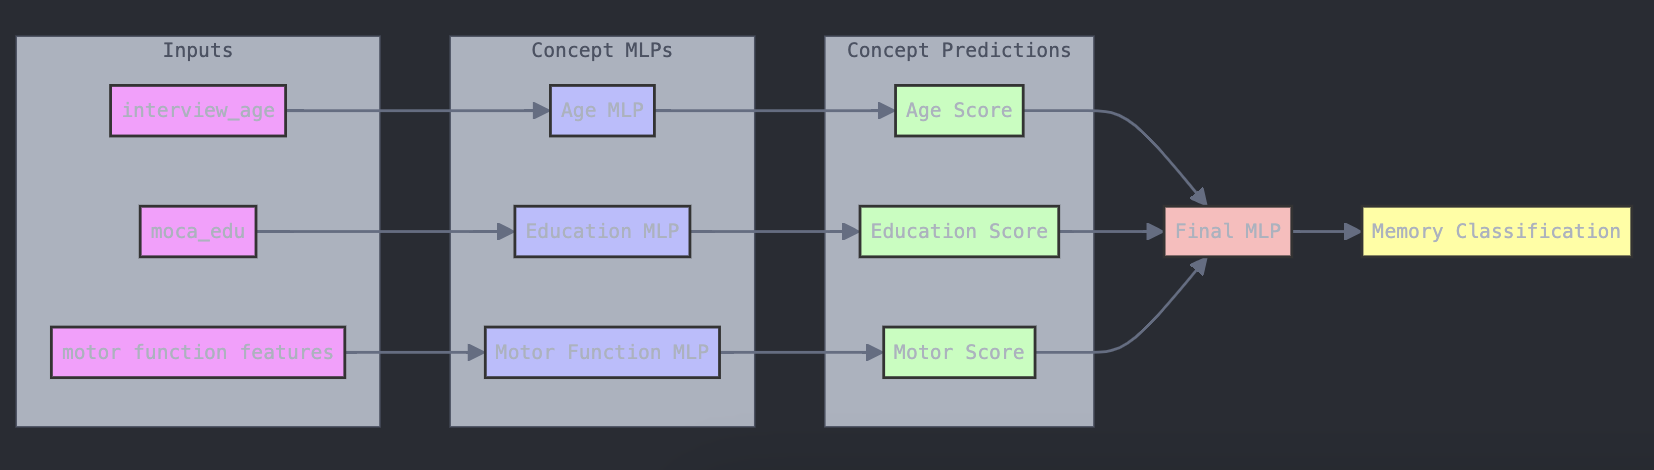

Concept Predictor Network (MLP)

Input Layer → Features specific to concept

↓

Hidden Layer (32 units) + BatchNorm + ReLU + Dropout(0.2)

↓

Hidden Layer (16 units) + BatchNorm + ReLU + Dropout(0.2)

↓

Output Layer (1 unit) + Sigmoid

Final Predictor Network (MLP)

Input Layer (3 units) → Concept scores

↓

Hidden Layer (64 units) + BatchNorm + ReLU + Dropout(0.3)

↓

Hidden Layer (32 units) + BatchNorm + ReLU + Dropout(0.3)

↓

Hidden Layer (16 units) + BatchNorm + ReLU + Dropout(0.3)

↓

Output Layer (1 unit) + Sigmoid

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.impute import KNNImputer
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from difflib import SequenceMatcher
import warnings
warnings.filterwarnings('ignore')

class ConceptPredictor(nn.Module):
    def __init__(self, input_size):
        super(ConceptPredictor, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

class MLPFinalPredictor(nn.Module):
    def __init__(self, num_concepts=3):  # Changed to 3 for age, education, and motor
        super(MLPFinalPredictor, self).__init__()

        self.network = nn.Sequential(
            # First hidden layer
            nn.Linear(num_concepts, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            # Second hidden layer
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),

            # Third hidden layer
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.3),

            # Output layer
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

def validate_feature_groups(df, feature_groups):
    """Validates feature groups against available data columns"""
    available_features = df.columns.tolist()
    missing_features = {}
    is_valid = True

    for concept, features in feature_groups.items():
        missing = [f for f in features if f not in available_features]
        if missing:
            is_valid = False
            missing_features[concept] = missing

            print(f"\nWarning: Missing features in {concept.upper()} group:")
            for feat in missing:
                print(f"  - {feat}")
                suggestions = suggest_similar_features(feat, available_features)
                if suggestions:
                    print("    Similar available features:")
                    for suggestion in suggestions[:3]:
                        print(f"    * {suggestion}")

    if not is_valid:
        print("\nAvailable features in dataset:")
        print(sorted(available_features))

    return is_valid

def suggest_similar_features(missing_feature, available_features, threshold=0.6):
    """Suggests similar feature names using string similarity"""
    suggestions = []
    for feat in available_features:
        similarity = SequenceMatcher(None, missing_feature.lower(), feat.lower()).ratio()
        if similarity > threshold:
            suggestions.append((feat, similarity))
    return [feat for feat, _ in sorted(suggestions, key=lambda x: x[1], reverse=True)]



def load_and_preprocess_data():
    # Load data
    print("Loading data...")
    moca_df = pd.read_csv('/content/drive/MyDrive/Risk/moca01.txt', sep='\t')
    motor_df = pd.read_csv('/content/drive/MyDrive/Risk/tlbx_motor01.txt', sep='\t')

    print("Initial shapes - MOCA:", moca_df.shape, "Motor:", motor_df.shape)

    # Select key columns - ensure these exist in your datasets
    moca_cols = ['subjectkey', 'interview_age', 'moca_total', 'moca_edu']
    motor_cols = ['subjectkey', 'end_2m_standardsc', 'twomin_acss', 'raw_wet']

    # Verify columns exist
    for col in moca_cols:
        if col not in moca_df.columns:
            raise ValueError(f"Column {col} not found in MOCA dataset")
    for col in motor_cols:
        if col not in motor_df.columns:
            raise ValueError(f"Column {col} not found in Motor dataset")

    moca_df = moca_df[moca_cols].copy()
    motor_df = motor_df[motor_cols].copy()

    # Convert numeric columns
    numeric_moca_cols = [col for col in moca_cols if col != 'subjectkey']
    numeric_motor_cols = [col for col in motor_cols if col != 'subjectkey']

    moca_df[numeric_moca_cols] = moca_df[numeric_moca_cols].apply(pd.to_numeric, errors='coerce')
    motor_df[numeric_motor_cols] = motor_df[numeric_motor_cols].apply(pd.to_numeric, errors='coerce')

    # Merge datasets
    df = pd.merge(moca_df, motor_df, on='subjectkey', how='inner')
    print("Shape after merge:", df.shape)

    # Remove rows where all feature columns are NA
    feature_cols = numeric_moca_cols + numeric_motor_cols
    feature_cols.remove('moca_total')  # Remove target variable
    df = df.dropna(subset=feature_cols, how='all')

    # Create engineered features
    df['memory_class'] = (df['moca_total'] >= 26).astype(int)

    # Only create derived features if source features exist
    if all(col in df.columns for col in ['twomin_acss', 'raw_wet']):
        df['motor_efficiency'] = df['twomin_acss'] / df['raw_wet']

    motor_cols = ['raw_wet', 'twomin_acss', 'end_2m_standardsc']
    if all(col in df.columns for col in motor_cols):
        df['motor_score'] = df[motor_cols].mean(axis=1)

        for col in motor_cols:
            df[f'{col}_rank'] = df[col].rank(pct=True)

        if 'interview_age' in df.columns:
            df['age_adjusted_motor'] = df['motor_score'] / df['interview_age']

    # Define feature groups - only include features that exist
    feature_groups = {
        'age': ['interview_age'],
        'education': ['moca_edu'],
        'motor_function': [col for col in [
            'raw_wet', 'twomin_acss', 'end_2m_standardsc',
            'motor_efficiency', 'motor_score',
            'raw_wet_rank', 'twomin_acss_rank', 'end_2m_standardsc_rank',
            'age_adjusted_motor'
        ] if col in df.columns]
    }

    # Verify each group has at least one feature
    # Process each feature group separately
    for group_name, group_features in feature_groups.items():
        print(f"\nProcessing {group_name} features...")

        # Skip empty feature groups
        if not group_features:
            print(f"Warning: Skipping empty feature group {group_name}")
            continue

        # Debug print
        print(f"Features in {group_name} group:", group_features)
        print(f"Data shape before processing:", df[group_features].shape)

        # Extract and check group data
        try:
            group_data = df[group_features]

            # Check if we have any valid data
            if group_data.empty or group_data.shape[1] == 0:
                raise ValueError(f"No valid data found for {group_name} group")

            # Convert to numpy array
            group_data = group_data.values

            # Debug print
            print(f"Group data shape:", group_data.shape)

            # Handle single feature case
            if len(group_data.shape) == 1 or group_data.shape[1] == 1:
                group_data = group_data.reshape(-1, 1)
                print(f"Reshaped to:", group_data.shape)

            # Additional shape verification
            if group_data.shape[1] == 0:
                raise ValueError(f"Empty feature array for {group_name} group")

            # Verify we have enough samples for KNN imputation
            n_neighbors = min(5, group_data.shape[0] - 1)
            if n_neighbors < 1:
                raise ValueError(f"Not enough samples for imputation in {group_name} group")

            # Impute missing values
            imputer = KNNImputer(n_neighbors=n_neighbors, weights='distance')
            imputed_data = imputer.fit_transform(group_data)
            print(f"Imputed data shape:", imputed_data.shape)

            # Scale features
            scaler = StandardScaler()
            scaled_data = scaler.fit_transform(imputed_data)
            print(f"Scaled data shape:", scaled_data.shape)

            # Assign back to dataframe
            for i, feature in enumerate(group_features):
                df[feature] = scaled_data[:, i]

        except Exception as e:
            print(f"Error processing {group_name} group: {str(e)}")
            # Skip this group if there's an error
            continue

    # Verify we have processed features
    processed_features = []
    for group in feature_groups.values():
        processed_features.extend([f for f in group if f in df.columns and not df[f].isna().all()])

    if not processed_features:
        raise ValueError("No valid features remaining after processing")

    print("\nFinal processed features:", processed_features)
    print("Shape of final dataset:", df.shape)
    print("\nMemory Class Distribution:")
    print(df['memory_class'].value_counts(normalize=True))

    return df, processed_features, feature_groups

# Update feature groups definition to ensure we have valid features
feature_groups = {
    'age': ['interview_age'],
    'education': ['moca_edu'],
    'motor_function': [
        'raw_wet', 'twomin_acss', 'end_2m_standardsc',
        'motor_efficiency', 'motor_score',
        'raw_wet_rank', 'twomin_acss_rank', 'end_2m_standardsc_rank',
        'age_adjusted_motor'
    ]
}

# Add print statements to check data at key points
print("Initial feature groups:", feature_groups)
df, features, updated_groups = load_and_preprocess_data()
print("\nFinal processed features:", features)


class ConceptBottleneckModel:
    def __init__(self, feature_indices):
        """
        feature_indices: dict with keys as concept names and values as lists of feature indices
        """
        self.feature_indices = feature_indices
        self.concept_predictors = {}
        self.final_predictor = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def train_concept_predictors(self, X_train, y_train, X_val, y_val, epochs=500):
        concept_outputs_train = []
        concept_outputs_val = []

        for concept, indices in self.feature_indices.items():
            print(f"\nTraining {concept} predictor...")

            # Create predictor
            predictor = ConceptPredictor(len(indices)).to(self.device)
            optimizer = torch.optim.Adam(predictor.parameters(), lr=0.001, weight_decay=1e-5)
            criterion = nn.BCELoss()

            # Convert data to tensors
            X_train_concept = torch.FloatTensor(X_train[:, indices]).to(self.device)
            X_val_concept = torch.FloatTensor(X_val[:, indices]).to(self.device)
            y_train_tensor = torch.FloatTensor(y_train).to(self.device)
            y_val_tensor = torch.FloatTensor(y_val).to(self.device)

            # Training loop
            best_loss = float('inf')
            patience = 20
            patience_counter = 0

            for epoch in range(epochs):
                predictor.train()
                optimizer.zero_grad()

                outputs = predictor(X_train_concept).squeeze()
                loss = criterion(outputs, y_train_tensor)

                loss.backward()
                optimizer.step()

                # Validation
                with torch.no_grad():
                    predictor.eval()
                    val_outputs = predictor(X_val_concept).squeeze()
                    val_loss = criterion(val_outputs, y_val_tensor)

                    if val_loss < best_loss:
                        best_loss = val_loss
                        patience_counter = 0
                        best_model = predictor.state_dict()
                    else:
                        patience_counter += 1

                    if patience_counter >= patience:
                        print(f'Early stopping at epoch {epoch+1}')
                        break

                    if (epoch + 1) % 100 == 0:
                        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

            # Load best model
            predictor.load_state_dict(best_model)
            self.concept_predictors[concept] = predictor

            # Get concept predictions
            with torch.no_grad():
                predictor.eval()
                train_preds = predictor(X_train_concept).squeeze().cpu().numpy()
                val_preds = predictor(X_val_concept).squeeze().cpu().numpy()

                concept_outputs_train.append(train_preds)
                concept_outputs_val.append(val_preds)

                print(f"{concept} predictor ROC-AUC: {roc_auc_score(y_val, val_preds):.4f}")

        return np.array(concept_outputs_train).T, np.array(concept_outputs_val).T

    def train_final_predictor(self, concept_outputs_train, concept_outputs_val, y_train, y_val, epochs=500):
        print("\nTraining final predictor...")

        # Initialize final predictor
        self.final_predictor = MLPFinalPredictor(num_concepts=len(self.feature_indices)).to(self.device)
        optimizer = torch.optim.Adam(self.final_predictor.parameters(), lr=0.001, weight_decay=1e-5)
        criterion = nn.BCELoss()

        # Convert data to tensors
        X_train_tensor = torch.FloatTensor(concept_outputs_train).to(self.device)
        X_val_tensor = torch.FloatTensor(concept_outputs_val).to(self.device)
        y_train_tensor = torch.FloatTensor(y_train).to(self.device)
        y_val_tensor = torch.FloatTensor(y_val).to(self.device)

        # Training loop with early stopping
        best_loss = float('inf')
        patience = 20
        patience_counter = 0

        for epoch in range(epochs):
            self.final_predictor.train()
            optimizer.zero_grad()

            outputs = self.final_predictor(X_train_tensor).squeeze()
            loss = criterion(outputs, y_train_tensor)

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                self.final_predictor.eval()
                val_outputs = self.final_predictor(X_val_tensor).squeeze()
                val_loss = criterion(val_outputs, y_val_tensor)

                if val_loss < best_loss:
                    best_loss = val_loss
                    patience_counter = 0
                    best_model = self.final_predictor.state_dict()
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

                if (epoch + 1) % 100 == 0:
                    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

        # Load best model
        self.final_predictor.load_state_dict(best_model)

        # Final evaluation
        with torch.no_grad():
            self.final_predictor.eval()
            final_preds = self.final_predictor(X_val_tensor).squeeze().cpu().numpy()
            print(f"Final predictor ROC-AUC: {roc_auc_score(y_val, final_preds):.4f}")
            print(f"Final predictor PR-AUC: {average_precision_score(y_val, final_preds):.4f}")

def prepare_data_for_training(df, features, feature_groups):
    """Prepare data for the concept bottleneck model training"""
    X = df[features].values
    y = df['memory_class'].values

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply SMOTE to balance training data
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

    # Create feature indices for each concept
    feature_indices = {}
    for concept, feat_list in feature_groups.items():
        try:
            feature_indices[concept] = [features.index(f) for f in feat_list]
        except ValueError as e:
            print(f"\nError creating feature indices for {concept}:")
            print(f"Could not find feature: {str(e)}")
            print("Available features:", features)
            raise

    return (X_train_balanced, X_test_scaled, y_train_balanced, y_test,
            feature_indices)

def run_concept_bottleneck_analysis():
    # Load and preprocess data
    df, features, feature_groups = load_and_preprocess_data()

    # Prepare data for training
    data = prepare_data_for_training(df, features, feature_groups)
    X_train_balanced, X_test_scaled, y_train_balanced, y_test, feature_indices = data

    # Initialize and train model
    cbm = ConceptBottleneckModel(feature_indices)

    # Train concept predictors
    concept_outputs_train, concept_outputs_test = cbm.train_concept_predictors(
        X_train_balanced, y_train_balanced, X_test_scaled, y_test
    )

    # Train final predictor
    cbm.train_final_predictor(
        concept_outputs_train, concept_outputs_test,
        y_train_balanced, y_test
    )

    return cbm, data

if __name__ == "__main__":
    # Print available columns first
    moca_df = pd.read_csv('/content/drive/MyDrive/Risk/moca01.txt', sep='\t')
    print("Available columns in MOCA dataset:")
    print(moca_df.columns.tolist())

    # Then run the analysis
    cbm, data = run_concept_bottleneck_analysis()

Initial feature groups: {'age': ['interview_age'], 'education': ['moca_edu'], 'motor_function': ['raw_wet', 'twomin_acss', 'end_2m_standardsc', 'motor_efficiency', 'motor_score', 'raw_wet_rank', 'twomin_acss_rank', 'end_2m_standardsc_rank', 'age_adjusted_motor']}
Loading data...
Initial shapes - MOCA: (725, 76) Motor: (1865, 65)
Shape after merge: (1864, 7)

Processing age features...
Features in age group: ['interview_age']
Data shape before processing: (1864, 1)
Group data shape: (1864, 1)
Reshaped to: (1864, 1)
Imputed data shape: (1864, 1)
Scaled data shape: (1864, 1)

Processing education features...
Features in education group: ['moca_edu']
Data shape before processing: (1864, 1)
Group data shape: (1864, 1)
Reshaped to: (1864, 1)
Imputed data shape: (1864, 1)
Scaled data shape: (1864, 1)

Processing motor_function features...
Features in motor_function group: ['raw_wet', 'twomin_acss', 'end_2m_standardsc', 'motor_efficiency', 'motor_score', 'raw_wet_rank', 'twomin_acss_rank', 'en

From Concept Bottleneck Model

In [ ]:
def convert_continuous_back_to_ordinal(y_true, y_pred, use_integer_bins=False):
    # Convert y_true into categories
    unique_y_true = np.unique(y_true)  # (C,)
    N_classes = len(unique_y_true)
    one_hot_y_true = (y_true[:, None] == unique_y_true[None, :]) # (N,C)
    cat_y_true = np.dot(one_hot_y_true, np.arange(N_classes))  # (N,)
    y_pred_binned_i = assign_value_to_bins(y_pred, unique_y_true, use_integer_bins=use_integer_bins)
    return y_pred_binned_i, cat_y_true




1. Random Forest

Paper source: https://www.nature.com/articles/s43587-024-00573-8#code-availability

Input Features:
- Age measurements
- Motor/gait measurements (end_2m_standardsc, twomin_acss, raw_wet)
- Engineered features (ratios, rankings, age-adjusted scores)

Output:
- Binary classification (0/1)

Model Parameters:
- Random Forest with 1000 trees
- Max depth: 12
- Class weight: balanced_subsample
- SMOTE for class balance



Final dataset shape: (1864, 16)

Memory Class Distribution:
memory_class
1    0.635193
0    0.364807
Name: proportion, dtype: float64

Cross-validation ROC-AUC scores: [0.84877471 0.83347257 0.85433027 0.86942356 0.88995269]
Mean CV ROC-AUC: 0.859 (+/- 0.038)

Test Set Performance:
AUROC: 0.785
Sensitivity: 0.789
Specificity: 0.632
Precision: 0.789

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.63      0.63       136
           1       0.79      0.79      0.79       237

    accuracy                           0.73       373
   macro avg       0.71      0.71      0.71       373
weighted avg       0.73      0.73      0.73       373



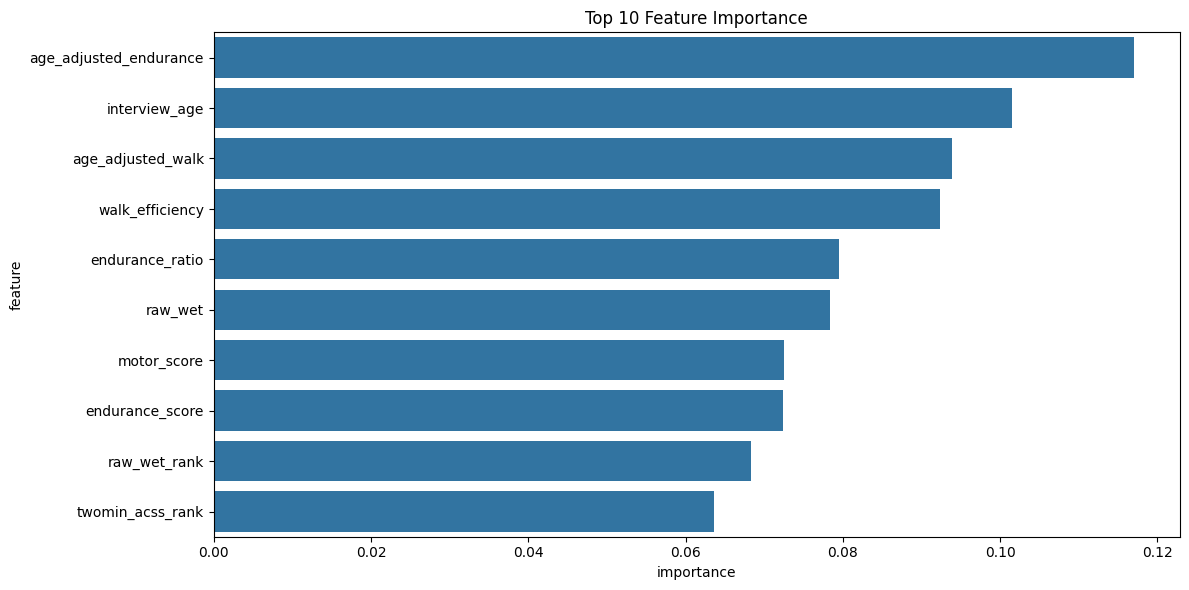

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_preprocess_data():
    # Load data
    moca_df = pd.read_csv('/content/drive/MyDrive/Risk/moca01.txt', sep='\t')
    motor_df = pd.read_csv('/content/drive/MyDrive/Risk/tlbx_motor01.txt', sep='\t')

    # Select key columns and convert to numeric
    moca_cols = ['subjectkey', 'interview_age', 'moca_total']
    motor_cols = ['subjectkey', 'end_2m_standardsc', 'twomin_acss', 'raw_wet']

    moca_df = moca_df[moca_cols]
    motor_df = motor_df[motor_cols]

    # Convert to numeric
    for df in [moca_df, motor_df]:
        for col in df.columns:
            if col != 'subjectkey':
                df[col] = pd.to_numeric(df[col], errors='coerce')

    # Merge datasets
    df = pd.merge(moca_df, motor_df, on='subjectkey', how='inner')

    # Create memory classification
    df['memory_class'] = (df['moca_total'] >= 26).astype(int)

    # Enhanced motor feature engineering
    # 1. Basic ratios
    df['endurance_ratio'] = df['raw_wet'] / df['end_2m_standardsc']
    df['walk_efficiency'] = df['twomin_acss'] / df['raw_wet']

    # 2. Motor performance scores
    df['motor_score'] = (df['raw_wet'] + df['twomin_acss']) / 2
    df['endurance_score'] = df['raw_wet'] * df['end_2m_standardsc']

    # 3. Normalized rankings
    for col in ['raw_wet', 'twomin_acss', 'end_2m_standardsc']:
        df[f'{col}_rank'] = df[col].rank(pct=True)

    # 4. Age-adjusted scores
    df['age_adjusted_endurance'] = df['raw_wet'] / df['interview_age']
    df['age_adjusted_walk'] = df['twomin_acss'] / df['interview_age']

    # Handle missing values
    from sklearn.impute import KNNImputer

    numeric_cols = [col for col in df.columns if col not in ['subjectkey', 'memory_class', 'moca_total']]
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

    # Scale features
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    # Final feature list
    features = numeric_cols

    print("\nFinal dataset shape:", df.shape)
    print("\nMemory Class Distribution:")
    print(df['memory_class'].value_counts(normalize=True))

    return df, features

def train_and_evaluate_model(df, features):
    X = df[features]
    y = df['memory_class']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Apply SMOTE to balance training data
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # Enhanced Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=1000,
        max_depth=12,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features='sqrt',
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1
    )

    # Cross-validation on balanced data
    cv_scores = cross_val_score(rf_model, X_train_balanced, y_train_balanced,
                              cv=5, scoring='roc_auc')

    # Train final model
    rf_model.fit(X_train_balanced, y_train_balanced)

    # Predictions
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

    # Print results
    print_detailed_results(cv_scores, X_test, y_test, y_pred, y_pred_proba,
                         rf_model, features)

    return rf_model, X_test, y_test

def print_detailed_results(cv_scores, X_test, y_test, y_pred, y_pred_proba, model, features):
    print("\nCross-validation ROC-AUC scores:", cv_scores)
    print("Mean CV ROC-AUC: {:.3f} (+/- {:.3f})".format(
        cv_scores.mean(), cv_scores.std() * 2))

    # Basic metrics
    auroc = roc_auc_score(y_test, y_pred_proba)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    print("\nTest Set Performance:")
    print(f"AUROC: {auroc:.3f}")
    print(f"Sensitivity: {tp/(tp+fn):.3f}")
    print(f"Specificity: {tn/(tn+fp):.3f}")
    print(f"Precision: {tp/(tp+fp):.3f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Feature importance
    importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(x='importance', y='feature', data=importance.head(10))
    plt.title('Top 10 Feature Importance')
    plt.tight_layout()
    plt.show()

    return importance

# Run analysis
df, features = load_and_preprocess_data()
model, X_test, y_test = train_and_evaluate_model(df, features)

2. SVM, KNN, RF and Naive Bayes

Paper source: https://www.nature.com/articles/s41598-024-51985-w#code-availibility

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading and preprocessing data...
Initial shapes:
MoCA data: (725, 76)
Motor data: (1865, 65)

Before merge:
MoCA unique subjects: 725
Motor unique subjects: 635

After merge: (1864, 6)

Missing values before imputation:
subjectkey              0
interview_age           0
moca_total              0
end_2m_standardsc    1269
twomin_acss          1273
raw_wet              1255
memory_class            0
dtype: int64

Selected features: ['interview_age', 'end_2m_standardsc', 'raw_wet']

Final dataset shape: (1864, 7)

Memory Class Distribution:
memory_class
1    0.635193
0    0.364807
Name: proportion, dtype: float64

Training models...

Training RF...
RF Performance:
Accuracy: 0.670
Precision: 0.694
Recall: 0.861
F1: 0.768

Training KNN...
KNN Performance:
Accuracy: 0.705
Precision: 0.775
Recall: 0.755
F1: 0.765

Training NB...
NB Performance:
Accuracy: 0.619
Precision: 0.639
Recall: 0.920
F1: 0.754

Training SVM...
SVM Performance:
Accuracy: 0.670
Precision: 0.682
Recall: 0.903
F1: 0.777


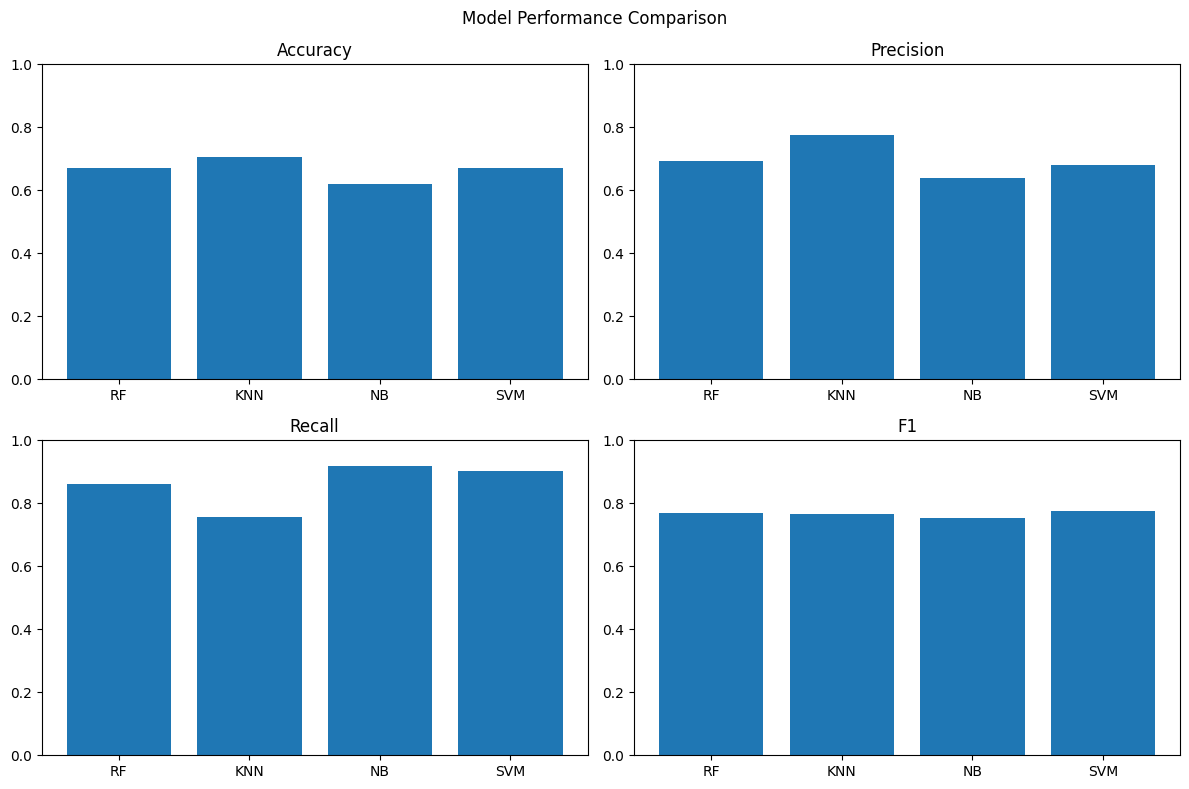

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

def load_and_preprocess_data():
    # Load data with proper parsing of subject IDs
    try:
        moca_df = pd.read_csv('/content/drive/MyDrive/Risk/moca01.txt', sep='\t')
        motor_df = pd.read_csv('/content/drive/MyDrive/Risk/tlbx_motor01.txt', sep='\t')

        print("Initial shapes:")
        print("MoCA data:", moca_df.shape)
        print("Motor data:", motor_df.shape)

        # Ensure subjectkey is treated as string
        moca_df['subjectkey'] = moca_df['subjectkey'].astype(str)
        motor_df['subjectkey'] = motor_df['subjectkey'].astype(str)

        # Select key features
        moca_cols = ['subjectkey', 'interview_age', 'moca_total']
        motor_cols = ['subjectkey', 'end_2m_standardsc', 'twomin_acss', 'raw_wet']

        # Select columns
        moca_df = moca_df[moca_cols]
        motor_df = motor_df[motor_cols]

        # Convert numeric columns
        for df in [moca_df, motor_df]:
            for col in df.columns:
                if col != 'subjectkey':
                    df[col] = pd.to_numeric(df[col], errors='coerce')

        print("\nBefore merge:")
        print("MoCA unique subjects:", moca_df['subjectkey'].nunique())
        print("Motor unique subjects:", motor_df['subjectkey'].nunique())

        # Merge datasets
        df = pd.merge(moca_df, motor_df, on='subjectkey', how='inner')
        print("\nAfter merge:", df.shape)

        # Create memory classification (MoCA ≥26 = normal)
        df['memory_class'] = (df['moca_total'] >= 26).astype(int)

        # Handle missing values
        print("\nMissing values before imputation:")
        print(df.isnull().sum())

        # Remove rows with too many missing values (>50%)
        df = df.dropna(thresh=len(df.columns)//2)

        # Fill remaining missing values with median
        numeric_cols = ['interview_age', 'end_2m_standardsc', 'twomin_acss', 'raw_wet']
        for col in numeric_cols:
            df[col] = df[col].fillna(df[col].median())

        # Feature selection using ANOVA F-test
        features = ['interview_age', 'end_2m_standardsc', 'twomin_acss', 'raw_wet']
        X = df[features]
        y = df['memory_class']

        # Scale features
        scaler = StandardScaler()
        df[features] = scaler.fit_transform(df[features])

        # Select top features
        selector = SelectKBest(f_classif, k=3)
        X_selected = selector.fit_transform(X, y)
        selected_features = [features[i] for i in selector.get_support(indices=True)]

        print("\nSelected features:", selected_features)
        print("\nFinal dataset shape:", df.shape)
        print("\nMemory Class Distribution:")
        print(df['memory_class'].value_counts(normalize=True))

        return df, selected_features

    except Exception as e:
        print(f"Error in data processing: {str(e)}")
        return None, None

def train_and_evaluate_models(df, features):
    X = df[features]
    y = df['memory_class']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Models
    models = {
        'RF': RandomForestClassifier(
            n_estimators=100,
            max_depth=5,
            min_samples_split=10,
            min_samples_leaf=4,
            class_weight='balanced',
            random_state=42
        ),
        'KNN': KNeighborsClassifier(
            n_neighbors=5,
            weights='distance'
        ),
        'NB': GaussianNB(),
        'SVM': SVC(
            kernel='rbf',
            probability=True,
            class_weight='balanced',
            random_state=42
        )
    }

   # Train and evaluate each model
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Train model
        model.fit(X_train, y_train)

        # Get predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred)
        }

        print(f"{name} Performance:")
        for metric, value in metrics.items():
            print(f"{metric.capitalize()}: {value:.3f}")

        results[name] = {
            'model': model,
            'metrics': metrics
        }

    return results, X_test, y_test

def main():
    # Load and preprocess data
    print("Loading and preprocessing data...")
    df, features = load_and_preprocess_data()

    if df is not None:
        # Train and evaluate models
        print("\nTraining models...")
        results, X_test, y_test = train_and_evaluate_models(df, features)

        # Print comparative results
        print("\nComparative Model Performance:")
        print("\nF1 Scores:")
        for name, result in results.items():
            print(f"{name}: {result['metrics']['f1']:.3f}")

        return results, features
    else:
        print("Data processing failed")
        return None, None

# Execute
results, features = main()

# Plot comparative results if desired
import matplotlib.pyplot as plt

def plot_results(results):
    """
    Plot comparative results of all models
    """
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Model Performance Comparison')

    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]
        values = [result['metrics'][metric] for result in results.values()]
        ax.bar(results.keys(), values)
        ax.set_title(metric.capitalize())
        ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

plot_results(results)

3. Lasso and NN


In [ ]:
import torch
import torch.nn as nn
from sklearn.linear_model import LogisticRegressionCV
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

def train_and_evaluate_models(df, features):
    # Prepare data
    X = df[features].values
    y = df['memory_class'].values

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply SMOTE to balance training data
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_balanced)
    y_train_tensor = torch.FloatTensor(y_train_balanced)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.FloatTensor(y_test)

    # Initialize models
    nn_model = ADNeuralNetwork(input_size=len(features))
    lasso_model = LogisticRegressionCV(
        penalty='l1',
        solver='saga',
        cv=5,
        random_state=42,
        max_iter=2000,  # Increased max iterations
        class_weight='balanced',  # Add class weights
        Cs=20  # Increase number of C values to try
    )

    # Train LASSO
    print("Training LASSO model...")
    lasso_model.fit(X_train_balanced, y_train_balanced)

    # Train Neural Network
    print("\nTraining Neural Network...")
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001, weight_decay=1e-5)  # Added weight decay

    # Add early stopping
    best_loss = float('inf')
    patience = 20
    patience_counter = 0
    best_model = None

    for epoch in range(1000):  # Increased epochs
        nn_model.train()
        optimizer.zero_grad()

        outputs = nn_model(X_train_tensor).squeeze()
        loss = criterion(outputs, y_train_tensor)

        loss.backward()
        optimizer.step()

        # Validation phase
        with torch.no_grad():
            nn_model.eval()
            test_outputs = nn_model(X_test_tensor).squeeze()
            test_loss = criterion(test_outputs, y_test_tensor)

            if test_loss < best_loss:
                best_loss = test_loss
                patience_counter = 0
                best_model = nn_model.state_dict()
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/1000], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

    # Load best model
    if best_model is not None:
        nn_model.load_state_dict(best_model)

    # Evaluate models
    with torch.no_grad():
        nn_model.eval()
        nn_preds = nn_model(X_test_tensor).squeeze().numpy()
    lasso_preds = lasso_model.predict_proba(X_test_scaled)[:, 1]

    # Print detailed results
    print("\nModel Performance:")
    print("\nLASSO Model:")
    print(f"ROC-AUC: {roc_auc_score(y_test, lasso_preds):.4f}")
    print(f"PR-AUC: {average_precision_score(y_test, lasso_preds):.4f}")
    print(f"Best C value: {lasso_model.C_[0]:.4f}")

    print("\nNeural Network:")
    print(f"ROC-AUC: {roc_auc_score(y_test, nn_preds):.4f}")
    print(f"PR-AUC: {average_precision_score(y_test, nn_preds):.4f}")

    # Feature importance for LASSO
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Coefficient': lasso_model.coef_[0]
    })
    print("\nTop 5 Important Features (LASSO):")
    print(feature_importance.sort_values(by='Coefficient', key=abs, ascending=False).head())

    return nn_model, lasso_model, feature_importance

# Update the neural network architecture
class ADNeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(ADNeuralNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_size, input_size * 3),
            nn.BatchNorm1d(input_size * 3),  # Added BatchNorm
            nn.Dropout(0.2),
            nn.ReLU(),

            nn.Linear(input_size * 3, input_size),
            nn.BatchNorm1d(input_size),
            nn.Dropout(0.2),
            nn.ReLU(),

            nn.Linear(input_size, 22),
            nn.BatchNorm1d(22),
            nn.ReLU(),

            nn.Linear(22, 5),
            nn.BatchNorm1d(5),
            nn.ReLU(),

            nn.Linear(5, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

# Run the analysis
if __name__ == "__main__":
    df, features = load_and_preprocess_data()
    nn_model, lasso_model, feature_importance = train_and_evaluate_models(df, features)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Final dataset shape: (1864, 16)

Memory Class Distribution:
memory_class
1    0.635193
0    0.364807
Name: proportion, dtype: float64
Training LASSO model...

Training Neural Network...
Epoch [100/1000], Loss: 0.6497, Test Loss: 0.6605
Epoch [200/1000], Loss: 0.6420, Test Loss: 0.6426
Early stopping at epoch 227

Model Performance:

LASSO Model:
ROC-AUC: 0.6090
PR-AUC: 0.7152
Best C value: 1.6238

Neural Network:
ROC-AUC: 0.6648
PR-AUC: 0.7550

Top 5 Important Features (LASSO):
             Feature  Coefficient
3            raw_wet     1.507646
6        motor_score    -1.356200
0      interview_age     0.907457
5    walk_efficiency    -0.791610
1  end_2m_standardsc    -0.595526
